In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


# Featurization

In [5]:
def prepare(train):   
    train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    train['release_year'] = train['release_year']
    
    releaseDate = pd.to_datetime(train['release_date']) 
    train['release_dayofweek'] = releaseDate.dt.dayofweek 
    train['release_quarter'] = releaseDate.dt.quarter     
    
    

    train['originalBudget'] = train['budget']
    #Inflation simple formula
    train['inflationBudget'] = train['budget'] + train['budget']*1.8/100*(2018-train['release_year'])
    train['budget'] = np.log1p(train['budget']) 
    
    #popularity mean year
    train['_popularity_mean_year'] = train['popularity'] / train.groupby("release_year")["popularity"].transform('mean')
    #ratio of Budget to runtime
    train['_budget_runtime_ratio'] = train['budget']/train['runtime'] 
    #ratio of Budget to popolarity
    train['_budget_popularity_ratio'] = train['budget']/train['popularity']
    #budget year ratio
    train['_budget_year_ratio'] = train['budget']/(train['release_year']*train['release_year'])
    #eleaseYear popularity ratio
    train['_releaseYear_popularity_ratio'] = train['release_year']/train['popularity']
    train['_releaseYear_popularity_ratio2'] = train['popularity']/train['release_year']


    #no. of words on title
    train['title_word_count'] = train['title'].str.split().str.len()
    #no. of words on overview
    train['overview_word_count'] = train['overview'].str.split().str.len()
    #no. of words on tagline
    train['tagline_word_count'] = train['tagline'].str.split().str.len()
    
    
    #mean of runtime By Year
    train['meanruntimeByYear'] = train.groupby("release_year")["runtime"].aggregate('mean')
    #mean of Popularity By Year
    train['meanPopularityByYear'] = train.groupby("release_year")["popularity"].aggregate('mean')
    #mean of Budget By Year
    train['meanBudgetByYear'] = train.groupby("release_year")["budget"].aggregate('mean')
    #median of Budget By Year
    train['medianBudgetByYear'] = train.groupby("release_year")["budget"].aggregate('median')
    # log budget
    train['log_budget'] = np.log1p(train['budget'])
    return train

In [6]:
prepare(train)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,medianBudgetByYear,log_budget
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2.281232,0.438360,5,29.0,11.0,110.215385,6.811535,14.076521,16.588099,2.859601
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0.484913,2.062224,6,69.0,13.0,103.727273,7.374862,13.805315,16.993564,2.918008
2,3,NaN,15.009433,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0.217729,4.592856,1,21.0,10.0,107.952381,7.819374,13.525220,16.523561,2.773178
3,4,NaN,13.997833,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3.779604,0.264578,1,106.0,NaN,107.513514,8.867440,13.652508,16.811243,2.707906
4,5,NaN,0.000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,7.839243,0.127563,2,32.0,NaN,105.108434,8.382675,13.630995,16.648724,0.000000
5,6,NaN,15.894952,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,...,117.049702,0.008543,7,28.0,NaN,112.212121,8.073476,14.168878,17.034386,2.827015
6,7,NaN,16.454568,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,1.646886,0.607206,2,39.0,7.0,107.657895,6.925090,12.539734,16.096120,2.859601
7,8,NaN,0.000000,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,2.052288,0.487261,2,80.0,4.0,105.076923,7.533421,12.840829,16.118096,0.000000
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0.000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,...,13.908159,0.071900,3,75.0,5.0,109.673267,8.806983,13.122767,16.523561,0.000000
9,10,NaN,15.607270,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,tt0310281,en,A Mighty Wind,"In ""A Mighty Wind"", director Christopher Guest...",4.672036,...,0.642118,1.557345,3,50.0,7.0,106.594340,7.883397,13.065192,16.340439,2.809841


In [7]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,medianBudgetByYear,log_budget
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2.281232,0.438360,5,29.0,11.0,110.215385,6.811535,14.076521,16.588099,2.859601
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0.484913,2.062224,6,69.0,13.0,103.727273,7.374862,13.805315,16.993564,2.918008
2,3,NaN,15.009433,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0.217729,4.592856,1,21.0,10.0,107.952381,7.819374,13.525220,16.523561,2.773178
3,4,NaN,13.997833,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3.779604,0.264578,1,106.0,NaN,107.513514,8.867440,13.652508,16.811243,2.707906
4,5,NaN,0.000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,7.839243,0.127563,2,32.0,NaN,105.108434,8.382675,13.630995,16.648724,0.000000


In [9]:
train.fillna(value=0.0, inplace = True) 

In [10]:

train = train.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 
    ],axis=1)

In [11]:
train.head()

,id,budget,popularity,revenue,release_month,release_day,release_year,release_dayofweek,release_quarter,originalBudget,...,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,medianBudgetByYear,log_budget
0,1,16.454568,6.575393,12314651,2,20,15,4,1,14000000,...,2.281232,0.438360,5,29.0,11.0,110.215385,6.811535,14.076521,16.588099,2.859601
1,2,17.504390,8.248895,95149435,8,6,4,4,3,40000000,...,0.484913,2.062224,6,69.0,13.0,103.727273,7.374862,13.805315,16.993564,2.918008
2,3,15.009433,64.299990,13092000,10,10,14,4,4,3300000,...,0.217729,4.592856,1,21.0,10.0,107.952381,7.819374,13.525220,16.523561,2.773178
3,4,13.997833,3.174936,16000000,3,9,12,4,1,1200000,...,3.779604,0.264578,1,106.0,0.0,107.513514,8.867440,13.652508,16.811243,2.707906
4,5,0.000000,1.148070,3923970,2,5,9,3,1,0,...,7.839243,0.127563,2,32.0,0.0,105.108434,8.382675,13.630995,16.648724,0.000000


In [12]:
def prepare(train):   
    train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    train['release_year'] = train['release_year']
    
    releaseDate = pd.to_datetime(train['release_date']) 
    train['release_dayofweek'] = releaseDate.dt.dayofweek 
    train['release_quarter'] = releaseDate.dt.quarter     
    
    

    train['originalBudget'] = train['budget']
    train['inflationBudget'] = train['budget'] + train['budget']*1.8/100*(2018-train['release_year']) #Inflation simple formula
    train['budget'] = np.log1p(train['budget']) 
    

    train['_popularity_mean_year'] = train['popularity'] / train.groupby("release_year")["popularity"].transform('mean')
    train['_budget_runtime_ratio'] = train['budget']/train['runtime'] 
    train['_budget_popularity_ratio'] = train['budget']/train['popularity']
    train['_budget_year_ratio'] = train['budget']/(train['release_year']*train['release_year'])
    train['_releaseYear_popularity_ratio'] = train['release_year']/train['popularity']
    train['_releaseYear_popularity_ratio2'] = train['popularity']/train['release_year']

    
 


    train['title_word_count'] = train['title'].str.split().str.len()
    train['overview_word_count'] = train['overview'].str.split().str.len()
    train['tagline_word_count'] = train['tagline'].str.split().str.len()
    
    

    train['meanruntimeByYear'] = train.groupby("release_year")["runtime"].aggregate('mean')
    train['meanPopularityByYear'] = train.groupby("release_year")["popularity"].aggregate('mean')
    train['meanBudgetByYear'] = train.groupby("release_year")["budget"].aggregate('mean')
    train['medianBudgetByYear'] = train.groupby("release_year")["budget"].aggregate('median')

    train['log_budget'] = np.log1p(train['budget'])
    return train

In [13]:
prepare(test)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,medianBudgetByYear,log_budget
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0.000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,1.817458,0.550219,5.0,57.0,9.0,108.450549,8.504043,14.238501,17.034386,0.000000
1,3002,NaN,11.385103,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,16.293101,0.061376,6.0,29.0,16.0,111.646465,8.709992,13.831658,16.689075,2.516494
2,3003,NaN,0.000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,11.997238,0.083353,3.0,61.0,8.0,105.000000,7.790758,12.854733,16.811243,0.000000
3,3004,NaN,15.732433,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,1.163330,0.859601,1.0,50.0,10.0,108.179245,8.012020,12.392314,16.523561,2.817349
4,3005,NaN,14.508658,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,1.553915,0.643536,3.0,145.0,42.0,108.436508,8.658689,14.052408,17.013975,2.741398
5,3006,NaN,0.000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0120238,en,SubUrbia,A group of suburban teenagers try to support e...,8.679350,...,11.060736,0.090410,1.0,17.0,NaN,103.985401,7.370116,12.527911,16.454568,0.000000
6,3007,NaN,0.000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,tt1517177,de,Drei,Hanna and Simon are in a 20 year marriage with...,4.898882,...,2.041282,0.489888,1.0,52.0,3.0,106.784431,7.965342,12.853985,16.523561,0.000000
7,3008,NaN,17.216708,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://www.tigger.com,tt0220099,en,The Tigger Movie,"As it happens, everybody - Pooh, Piglet, Eeyor...",7.023414,...,0.000000,inf,3.0,61.0,NaN,108.039216,8.009915,12.732757,16.523561,2.902339
8,3009,NaN,16.618871,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://becomingjane-themovie.com/,tt0416508,en,Becoming Jane,A biographical portrait of a pre-fame Jane Aus...,7.829737,...,0.894027,1.118534,2.0,15.0,7.0,105.284848,7.929437,13.105172,16.523561,2.868971
9,3010,"[{'id': 10194, 'name': 'Toy Story Collection',...",18.315320,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story-2,tt0120363,en,Toy Story 2,"Andy heads off to Cowboy Camp, leaving his toy...",17.547693,...,5.641767,0.177249,3.0,57.0,4.0,107.393258,8.492387,12.290491,16.256912,2.960899


In [14]:
test = test.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 
    ],axis=1)

In [15]:
test.head()

,id,budget,popularity,release_month,release_day,release_year,release_dayofweek,release_quarter,originalBudget,inflationBudget,...,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,medianBudgetByYear,log_budget
0,3001,0.000000,3.851534,7,14,7,5.0,3.0,0,0.0,...,1.817458,0.550219,5.0,57.0,9.0,108.450549,8.504043,14.238501,17.034386,0.000000
1,3002,11.385103,3.559789,5,19,58,6.0,2.0,88000,3192640.0,...,16.293101,0.061376,6.0,29.0,16.0,111.646465,8.709992,13.831658,16.689075,2.516494
2,3003,0.000000,8.085194,5,23,97,4.0,2.0,0,0.0,...,11.997238,0.083353,3.0,61.0,8.0,105.000000,7.790758,12.854733,16.811243,0.000000
3,3004,15.732433,8.596012,9,4,10,5.0,3.0,6800000,252579200.0,...,1.163330,0.859601,1.0,50.0,10.0,108.179245,8.012020,12.392314,16.523561,2.817349
4,3005,14.508658,3.217680,2,11,5,4.0,1.0,2000000,74468000.0,...,1.553915,0.643536,3.0,145.0,42.0,108.436508,8.658689,14.052408,17.013975,2.741398


In [19]:
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

import time
from datetime import datetime
x = train.drop(['id', 'revenue'], axis=1)
y = train['revenue']
X_test = test.drop(['id'], axis=1)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

In [27]:
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

import time
from datetime import datetime
X_train = train.drop(['id', 'revenue'], axis=1)
Y_train = train['revenue']
X_test = test.drop(['id'], axis=1)

In [21]:
x_train.head()

,budget,popularity,release_month,release_day,release_year,release_dayofweek,release_quarter,originalBudget,inflationBudget,_popularity_mean_year,...,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,medianBudgetByYear,log_budget
1991,17.426428,3.742824,10,31,97,4,4,37000000,1.316386e+09,0.479765,...,25.916260,0.038586,1,14.0,5.0,0.0,0.0,0.0,0.0,2.913786
2532,19.336971,23.253089,11,26,12,0,4,250000000,9.277000e+09,2.839671,...,0.516060,1.937757,5,32.0,8.0,0.0,0.0,0.0,0.0,3.012440
1074,0.000000,7.631049,4,23,4,4,2,0,0.000000e+00,0.910336,...,0.524174,1.907762,6,126.0,4.0,0.0,0.0,0.0,0.0,0.000000
2696,15.424949,8.679349,3,29,85,4,1,5000000,1.789700e+08,1.137385,...,9.793361,0.102110,3,66.0,17.0,0.0,0.0,0.0,0.0,2.798801
215,17.370859,7.321172,2,7,13,3,1,35000000,1.298150e+09,0.857146,...,1.775672,0.563167,2,35.0,7.0,0.0,0.0,0.0,0.0,2.910766


In [22]:
y_train.head()

1991       6482195
2532    1021103568
1074      10000000
2696      27400000
215      173965010
Name: revenue, dtype: int64

In [23]:
x_valid.head()

,budget,popularity,release_month,release_day,release_year,release_dayofweek,release_quarter,originalBudget,inflationBudget,_popularity_mean_year,...,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear,medianBudgetByYear,log_budget
91,0.00000,3.831960,3,16,1,4,1,0,0.000000e+00,0.519597,...,0.260963,3.831960,3,27.0,0.0,103.904762,5.705369,9.276829,15.169536,0.000000
463,0.00000,8.098060,7,31,89,0,3,0,0.000000e+00,1.150721,...,10.990287,0.090989,1,40.0,12.0,0.000000,0.000000,0.000000,0.000000,0.000000
2283,0.00000,4.402840,8,8,12,2,3,0,0.000000e+00,0.537675,...,2.725514,0.366903,4,45.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2783,17.39903,8.867562,2,15,2,4,1,36000000,1.342368e+09,1.134050,...,0.225541,4.433781,2,54.0,11.0,0.000000,0.000000,0.000000,0.000000,2.912298
774,0.00000,14.679860,3,12,10,4,1,0,0.000000e+00,2.102889,...,0.681205,1.467986,1,34.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000


# xgboost

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from scipy.stats import randint as sp_randint
def xg_reg(x_train,x_valid, y_train):
    #Fine tuning
    c_param={'learning_rate' :stats.uniform(0.01,0.2),
      'n_estimators':sp_randint(10,1000),
      'max_depth':sp_randint(1,80),
      'min_child_weight':sp_randint(1,50),
      'gamma':stats.uniform(0,0.04),
      'subsample':stats.uniform(0.6,0.4),
      'reg_alpha':sp_randint(0,200),
      'reg_lambda':stats.uniform(0,200),
      'colsample_bytree':stats.uniform(0.6,0.3)}
   
    xreg= xgb.XGBRegressor(nthread = 4)
    #RandomSearchCV
    model3 = RandomizedSearchCV(xreg, param_distributions= c_param, scoring = "neg_mean_absolute_error", cv = 3)
    
    model3.fit(x_train, y_train,eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)
    
    y_pred = model3.predict(x_valid)
    xgb_test_predictions = [round(value) for value in y_pred]
    y_pred = model3.predict(x_train)
    xgb_train_predictions = [round(value) for value in y_pred]
    print(model3.best_params_)
    
    return xgb_train_predictions,xgb_test_predictions

In [31]:
xgb_train_predictions,xgb_test_predictions=xg_reg(x_train,x_valid, y_train)

[0]	validation_0-rmse:1.426e+08	validation_1-rmse:1.59397e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[82]	validation_0-rmse:6.95275e+07	validation_1-rmse:9.24872e+07

[0]	validation_0-rmse:1.4295e+08	validation_1-rmse:1.59841e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[276]	validation_0-rmse:5.569e+07	validation_1-rmse:8.96276e+07

[0]	validation_0-rmse:1.42183e+08	validation_1-rmse:1.58755e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[88]	validation_0-rmse:6.59164e+07	validation_1-rmse:8.80802e+07

[0]	validation_0-rmse:1.43344e+08	validation_1-rmse:1.60

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[589]	validation_0-rmse:5.67001e+07	validation_1-rmse:9.55659e+07
[0]	validation_0-rmse:1.44472e+08	validation_1-rmse:1.61469e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[384]	validation_0-rmse:5.95647e+07	validation_1-rmse:9.2286e+07

[0]	validation_0-rmse:1.44113e+08	validation_1-rmse:1.60925e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[161]	validation_0-rmse:6.8661e+07	validation_1-rmse:9.30099e+07

[0]	validation_0-rmse:1.38111e+08	validation_1-rmse:1.54236e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for e

In [32]:
xgbmodel = xgb.XGBRegressor(colsample_bytree= 0.7353097200993632, gamma= 0.002911864213301354,
                            learning_rate= 0.17028661557759184, max_depth=56 , 
                            min_child_weight= 20, n_estimators= 16, reg_alpha= 25,
                            reg_lambda= 36.04295414564442, subsample= 0.9170549552402483)

In [33]:
def rmsle(predictions, dmat):
    labels = dmat.get_label()
    diffs = numpy.log(predictions + 1) - numpy.log(labels + 1)
    squared_diffs = numpy.square(diffs)
    avg = numpy.mean(squared_diffs)
    return ('RMSLE', numpy.sqrt(avg))

In [34]:
xgbmodel.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

[0]	validation_0-rmse:1.38111e+08	validation_1-rmse:1.54236e+08
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[15]	validation_0-rmse:7.75284e+07	validation_1-rmse:9.67881e+07


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7353097200993632, gamma=0.002911864213301354,
       importance_type='gain', learning_rate=0.17028661557759184,
       max_delta_step=0, max_depth=56, min_child_weight=20, missing=None,
       n_estimators=16, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=25, reg_lambda=36.04295414564442,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9170549552402483)

In [38]:
start1=time.time()
valid1=xgbmodel.predict(x_valid)
end1= time.time()
t1=end1-start1
t1

0.10264778137207031

In [39]:
xgbmodel.score(x_valid,y_valid)

0.5883303905253772

In [40]:
xgbmodel.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7353097200993632, gamma=0.002911864213301354,
       importance_type='gain', learning_rate=0.17028661557759184,
       max_delta_step=0, max_depth=56, min_child_weight=20, missing=None,
       n_estimators=16, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=25, reg_lambda=36.04295414564442,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9170549552402483)

In [44]:
#saving predictions to csv
test['revenue'] = xgbmodel.predict(X_test)
test[['id','revenue']].to_csv('submission_xgb.csv', index=False)
test[['id','revenue']].head()

,id,revenue
0,3001,8141865.0
1,3002,5390163.0
2,3003,25629840.0
3,3004,19291872.0
4,3005,3509860.0


# lightgbm

In [45]:
import lightgbm as lgb
def lgbmodel(x_train,x_valid, y_train):
    #Fine tuning
    c_param={'learning_rate' :stats.uniform(0.01,0.2),
      'n_estimators':sp_randint(100,1000),
      'num_leaves':sp_randint(1,30),
      'boosting_type' : ['gbdt'],
      'bagging_fraction' : stats.uniform(0.1, 0.8),
      'colsample_bytree':stats.uniform(0,0.2),
      'subsample':stats.uniform(0.8,0.4),
      'reg_alpha':sp_randint(0,200),
      'reg_lambda':stats.uniform(0,200)}
   
    lgbmodel= lgb.LGBMRegressor(nthread = 4)
    model3 = RandomizedSearchCV(lgbmodel, param_distributions= c_param, scoring = "neg_mean_absolute_error", cv = 3)
    
    model3.fit(x_train, y_train,eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='rmsle',
        verbose=1000, early_stopping_rounds=200)
    
    y_pred = model3.predict(x_valid)
    lgb_test_predictions = [round(value) for value in y_pred]
    l_pred = model3.predict(x_train)
    lgb_train_predictions = [round(value) for value in y_pred]
    print(model3.best_params_)
    
    return lgb_train_predictions,lgb_test_predictions

In [46]:
lgb_train_predictions,lgb_test_predictions=lgbmodel(x_train,x_valid, y_train)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[220]	valid_0's l2: 4.96611e+15	valid_1's l2: 8.19653e+15
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	valid_0's l2: 4.30935e+15	valid_1's l2: 7.67629e+15
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[230]	valid_0's l2: 4.58996e+15	valid_1's l2: 7.74392e+15
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[61]	valid_0's l2: 4.75764e+15	valid_1's l2: 8.16181e+15
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[68]	valid_0's l2: 4.44109e+15	valid_1's l2: 7.5824e+15
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[44]	valid_0's l2: 4.84564e+15	valid_1's l2: 7.55667e+15
Training until validation scores don't improve for 200 rounds.
Early

In [47]:
lgbmodel = lgb.LGBMRegressor(bagging_fraction= 0.3652874372414614,
                             boosting_type= 'gbdt', 
                             colsample_bytree= 0.014630156676258946,
                             learning_rate= 0.10249020880854486,
                             n_estimators= 823, num_leaves= 10, 
                             reg_alpha= 80, reg_lambda= 17.15256293208538,
                             subsample= 1.067666689279384)

In [48]:
from sklearn.metrics import mean_squared_log_error

In [49]:
lgbmodel.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[188]	training's l2: 5.0332e+15	training's rmse: 7.09451e+07	valid_1's l2: 7.6446e+15	valid_1's rmse: 8.74334e+07


LGBMRegressor(bagging_fraction=0.3652874372414614, boosting_type='gbdt',
       class_weight=None, colsample_bytree=0.014630156676258946,
       importance_type='split', learning_rate=0.10249020880854486,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=823, n_jobs=-1, num_leaves=10,
       objective=None, random_state=None, reg_alpha=80,
       reg_lambda=17.15256293208538, silent=True,
       subsample=1.067666689279384, subsample_for_bin=200000,
       subsample_freq=0)

In [50]:
start1=time.time()
valid1=lgbmodel.predict(x_valid)
end1= time.time()
t1=end1-start1
t1

0.01791691780090332

In [51]:
lgbmodel.score(x_valid,y_valid)

0.6640619056295198

In [52]:
#saving predictions to csv
test['revenue'] = lgbmodel.predict(X_test)
test[['id','revenue']].to_csv('submission_lgb.csv', index=False)
test[['id','revenue']].head()

,id,revenue
0,3001,7.539970e+06
1,3002,-4.053703e+06
2,3003,2.220968e+07
3,3004,-1.591284e+07
4,3005,-3.637682e+07


In [68]:
x_train[x_train==np.inf]=np.nan
x_train.fillna(x_train.mean(), inplace=True)
y_train[y_train==np.inf]=np.nan
y_train.fillna(y_train.mean(), inplace=True)x_valid[x_valid==np.inf]=np.nan
x_valid.fillna(x_valid.mean(), inplace=True)

In [95]:
def RF_reg(df_train,df_test,train_output):
    #Fine tuning
    n_est = sp_randint(400,600)
    max_dep = sp_randint(10, 20)
    min_split = sp_randint(8, 15)
    start = [False]
    min_leaf = sp_randint(8, 15)
    c_param = {'n_estimators':n_est ,'max_depth': max_dep,'min_samples_split':min_split,\
               'min_samples_leaf':min_leaf ,'warm_start':start }
    
    RF_reg = RandomForestRegressor(max_features='sqrt',oob_score = TRUE, n_jobs=4)
    
    model2 =  RandomizedSearchCV(RF_reg, param_distributions= c_param, scoring = "neg_mean_absolute_error",n_jobs=4, cv=3)
    
    model2.fit(df_train, train_output)
    
    y_pred = model2.best_estimator_.predict(df_test)
    rndf_test_predictions = [round(value) for value in y_pred]
    y_pred = model2.best_estimator_.predict(df_train)
    rndf_train_predictions = [round(value) for value in y_pred]
    print(model2.best_params_)
    return rndf_train_predictions,rndf_test_predictions

In [71]:
from sklearn.ensemble import RandomForestRegressor
rf_train_predictions,rf_test_predictions = RF_reg(x_train,x_valid, y_train)

{'max_depth': 18, 'min_samples_leaf': 8, 'min_samples_split': 12, 'n_estimators': 444, 'warm_start': False}


In [80]:
X_train[X_train==np.inf]=np.nan
X_train.fillna(X_train.mean(), inplace=True)
Y_train[Y_train==np.inf]=np.nan
Y_train.fillna(Y_train.mean(), inplace=True)
X_test[X_test==np.inf]=np.nan
X_test.fillna(X_test.mean(), inplace=True)

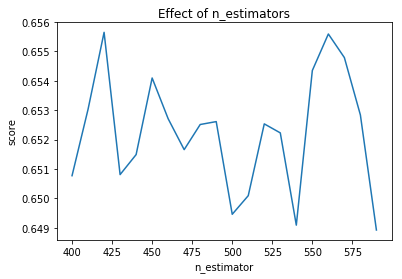

In [92]:
estimators = np.arange(400, 600, 10)
scores = []
for n in estimators:
    rfmodel.set_params(n_estimators=n)
    rfmodel.fit(x_train, y_train)
    scores.append(rfmodel.score(x_valid, y_valid))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

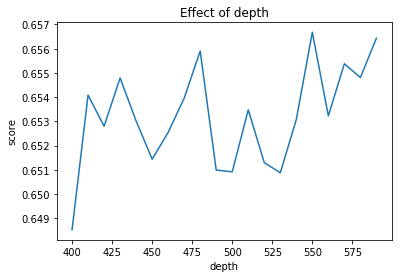

In [94]:
max_depth = np.arange(1, 20,1)
scores = []
for n in estimators:
    rfmodel.set_params(n_estimators=n)
    rfmodel.fit(x_train, y_train)
    scores.append(rfmodel.score(x_valid, y_valid))
plt.title("Effect of depth")
plt.xlabel("depth")
plt.ylabel("score")
plt.plot(estimators, scores)

In [101]:
rfmodel = RandomForestRegressor(n_estimators = 200, min_samples_leaf=8,min_samples_split=12,max_depth=18,oob_score = True, n_jobs = 4, max_features = "auto")

In [103]:
rfmodel.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [105]:
from sklearn.metrics import r2_score

In [106]:
start1=time.time()
valid1=rfmodel.predict(x_valid)
end1= time.time()
t1=end1-start1
t1

0.10871267318725586

In [107]:
rfmodel.score(x_valid,y_valid)

0.6519483321224786

In [77]:
rfmodel.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators=444, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [81]:
#saving predictions to csv
test['revenue'] = rfmodel.predict(X_test)
test[['id','revenue']].to_csv('submission_rf.csv', index=False)
test[['id','revenue']].head()

,id,revenue
0,3001,7.277252e+06
1,3002,1.441477e+07
2,3003,2.869336e+07
3,3004,2.539468e+07
4,3005,9.138782e+06


In [2]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ['S.no', 'Model Name', 'Root Mean Squared Error']
ptable.add_row(["1","Random forest","0.65"])
ptable.add_row(["2","Lightgbm","0.66"])
ptable.add_row(["3","XGBoost","0.58"])
print(ptable)

+------+---------------+-------------------------+
| S.no |   Model Name  | Root Mean Squared Error |
+------+---------------+-------------------------+
|  1   | Random forest |           0.65          |
|  2   |    Lightgbm   |           0.66          |
|  3   |    XGBoost    |           0.58          |
+------+---------------+-------------------------+
